<span style="color: orange; font-family: Calibri Light;">
  <h1><b>BERTopic Model: K-Means Clustering</b></h1>
</span>
<span style = "font-family: Calibri Light">
    In this model, we used the BerTopic model with kmeans clustering instead of hbdscan, on slightly pre-processed text. 
    Preprocess steps: removal of URLs, newline and tab and extra white spaces
</span>

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>I. Setup Environment</b></h2>
</span>

In [1]:
import os

os.environ['PATH'] = "/home/ec2-user/.local/bin:" + os.environ['PATH']

In [2]:
%pip install bertopic gensim

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Obtaining dependency information for bertopic from https://files.pythonhosted.org/packages/06/49/f395e2e4d21dd49803494c8aec6087db61ea0ba211c6e5e57540b23334eb/bertopic-0.15.0-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 7.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 100.9 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 1.7 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 369.7 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for plotly>=4.7.0 from h

In [1]:
import pandas as pd
import numpy as np

import re

import ast
import csv
import os
import random
import time
import pickle
from collections import Counter

from glob import glob

#NLP libraries
from gensim.models import Word2Vec
from gensim.utils import tokenize
from gensim.models.phrases import Phrases
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired
from bertopic.vectorizers import  ClassTfidfTransformer
from sentence_transformers import SentenceTransformer

#for vis
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = 'iframe'

from umap import UMAP

from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score

from hdbscan import HDBSCAN

2023-09-24 04:31:21.238755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 04:31:21.376308: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-24 04:31:22.114890: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-24 04:31:22.114971: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
random.seed(70)  # Set the seed for Python's random module
np.random.seed(70)  # Set the seed for NumPy's random module

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>II. Load and preprocess Data</b></h2>
</span>

In [3]:
#access dataset files
folder_path = os.path.join("..", "../Data")
file_type = "*.csv"

#list of dataset file paths
document_path = glob(os.path.join(folder_path, file_type))

document_path

['../../Data/comments.csv',
 '../../Data/emoji_subset.csv',
 '../../Data/full_posts.csv',
 '../../Data/bert_train_lemma.csv',
 '../../Data/bert_train_no_prep.csv',
 '../../Data/full_data_no_preprocessing.csv',
 '../../Data/subset_sample_no_label.csv',
 '../../Data/test_data_lemma.csv',
 '../../Data/bert-data-sw.csv']

In [4]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


train_data = pd.read_csv('../../Data/bert_train_no_prep.csv', converters ={'tokens':list_converter})
train_data = train_data.drop(columns = ['index'])
train_data = train_data.dropna(subset = ['long_text'])
train_data.head()

,text_type,ID,date_created,year,long_text
0,comment,gtfo2hl,2021-04-05 13:00:32,2021,"*Cuntry roads, take me hoem*"
1,comment,gtfqkbv,2021-04-05 13:41:40,2021,"That’s been there for several years, sent a pi..."
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...
4,comment,gtg5mwv,2021-04-05 16:51:54,2021,I am cunting on them to do so 😅


In [5]:
#check for empty values
train_data[train_data['long_text'].isna()]

,text_type,ID,date_created,year,long_text


In [6]:
#sort by data created
train_data.sort_values(by='date_created', inplace = True, ignore_index = True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127686 entries, 0 to 127685
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   text_type     127686 non-null  object
 1   ID            127686 non-null  object
 2   date_created  127686 non-null  object
 3   year          127686 non-null  int64 
 4   long_text     127686 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.9+ MB


In [7]:
#remove HTML, URLs and newline and tab characters

def text_preprocess(text):
    #remove HTMLs and URLs
    text = re.sub(r'<.*?>|http\S+', '', text)
    
    #remove newline and tab characters
    text = text.replace('\n', ' ').replace ('\t', ' ')
    
    #remove extra whitespace
    text = re.sub(r'\s+',' ', text)
    
    return text

train_data['prep_text'] = train_data['long_text'].apply(text_preprocess)

In [8]:
train_data.head()

,text_type,ID,date_created,year,long_text,prep_text
0,comment,c5c54q4,2012-07-11 00:50:58,2012,That dessert's a bit rich for me.,That dessert's a bit rich for me.
1,comment,c5edn0u,2012-07-15 21:59:34,2012,"""A SILVER one?! I HATE YOU DAD!""","""A SILVER one?! I HATE YOU DAD!"""
2,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...,Yet i stared at the picture for a good 45 seco...
3,comment,c6d1cs1,2012-09-25 08:04:04,2012,seriously?,seriously?
4,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i...","[FYSR] = from your sister subreddit. IMO, its ..."


In [9]:
#remove rows with less than 5 words
train_data = train_data[train_data['prep_text'].apply(lambda x:len(x.split()) > 5)]

In [10]:
train_data.head()

,text_type,ID,date_created,year,long_text,prep_text
0,comment,c5c54q4,2012-07-11 00:50:58,2012,That dessert's a bit rich for me.,That dessert's a bit rich for me.
1,comment,c5edn0u,2012-07-15 21:59:34,2012,"""A SILVER one?! I HATE YOU DAD!""","""A SILVER one?! I HATE YOU DAD!"""
2,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...,Yet i stared at the picture for a good 45 seco...
4,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i...","[FYSR] = from your sister subreddit. IMO, its ..."
5,comment,c6d46es,2012-09-25 12:32:08,2012,common give prince william harry a break he ju...,common give prince william harry a break he ju...


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98957 entries, 0 to 127683
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_type     98957 non-null  object
 1   ID            98957 non-null  object
 2   date_created  98957 non-null  object
 3   year          98957 non-null  int64 
 4   long_text     98957 non-null  object
 5   prep_text     98957 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.3+ MB


---

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>III. Train Model</b></h2>
</span>
<p>First, we will train the model using different n_clusters (20,30,50) and compare their performance using quantitative measures such as coherence and topic diversity.<br>
Coherence we will measure with 'c_v' and 'c_npmi', and topic diversity, we will measure uniqueness and exclusivity.</p>

In [12]:
#prepare data for bertopic model
docs = train_data['prep_text'].values

In [13]:
#prepare sub-models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=820)
vectorizer_model = CountVectorizer(max_df = 1000, min_df = 10, stop_words = 'english', ngram_range = (1,2))
ctfidf_model = ClassTfidfTransformer(bm25_weighting= True, reduce_frequent_words=True)
representation_model = MaximalMarginalRelevance(diversity = 0.5)
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/3093 [00:00<?, ?it/s]

In [14]:
#k-means sub model & train bert_model

cluster_range = [20,30,50]
cv_scores = []
cnpmi_scores = []
topic_uniqueness = []
topic_exclusivity = []
#loop over topics_range and calculate topic coherence and topic diversity

start_time = time.time()
for n_cluster in cluster_range:
    kmeans_model = KMeans (n_clusters = n_cluster, init = 'k-means++', n_init = 10, max_iter = 300, random_state = 10)
    
    #train bertopic model
    model = BERTopic(embedding_model=sentence_model, umap_model=umap_model, 
                 hdbscan_model = kmeans_model,vectorizer_model=vectorizer_model,
                    ctfidf_model=ctfidf_model, representation_model=representation_model)
    
    topics,_ = model.fit_transform(docs, embeddings)
    
    #calculate coherence score(c_v)
    topic_reps = model.get_topic_info()
    dictionary = Dictionary([words.split() for words in docs])
    corpus = [dictionary.doc2bow(doc.split()) for doc in docs]
    cv = CoherenceModel(topics = topic_reps['Representation'].tolist(),
                       texts = [doc.split() for doc in train_data['prep_text'].values],
                        dictionary = dictionary, coherence = 'c_v')
    cv_coherence =cv.get_coherence()
    cv_scores.append(cv_coherence)
    
    #calculate coherence score(c_npmi)
    cnpmi = CoherenceModel(topics = topic_reps['Representation'].tolist(),
                       texts = [doc.split() for doc in train_data['prep_text'].values],
                        dictionary = dictionary, coherence = 'c_npmi')
    cnpmi_coherence =cnpmi.get_coherence()
    cnpmi_scores.append(cnpmi_coherence)
    
    #calculate topic diversity - exclusivity
    n = 10
    #unique topics
    unique_topics = model.get_topic_freq()['Topic'].tolist()
    #remove outlier topics
    unique_topics = [topic for topic in unique_topics if topics != -1]
    #get top_n words for each topic
    topic_words = [model.get_topic(topic_id)[:n] for topic_id in unique_topics]
    all_top_words = [word for topic in topic_words for word,_ in topic]
    #calculate exclusivity
    word_counts = Counter(all_top_words)
    exclusivity = sum(1 for word, count in word_counts.items() if count == 1)/ len(all_top_words)
    topic_exclusivity.append(exclusivity)
    #calculate topic diversity - uniqueness
    uniqueness = len(set(all_top_words))/ (n * len(unique_topics))
    topic_uniqueness.append(uniqueness)
    
    
    print(f"For {n_cluster} topics:\nCoherence(c_v) = {cv_coherence},\nCoherence(c_npmi) = {cnpmi_coherence},\nTopic Diversity-Uniquesness = {uniqueness},\nTopic Diversity-Exclusivity = {exclusivity}")
    
print(f"This code took {(time.time() - start_time)/60 :.2f} minutes to execute")    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [15]:
evals = {'topics': cluster_range,'coherence(c_v)': cv_scores, 'coherence(c_npmi)':cnpmi_scores, 'topic_diveristy_uniqueness':topic_uniqueness, 'topic_diversity_exclusivity': topic_exclusivity}
bert_kmeans_lemma_eval = pd.DataFrame(evals)

bert_kmeans_lemma_eval.to_csv('training_results/bert_kmeans_prep_evals.csv')
bert_kmeans_lemma_eval

,topics,coherence(c_v),coherence(c_npmi),topic_diveristy_uniqueness,topic_diversity_exclusivity
0,20,0.346817,-0.182231,0.990,0.980
1,30,0.347594,-0.183653,0.940,0.880
2,50,0.325538,-0.216880,0.936,0.878


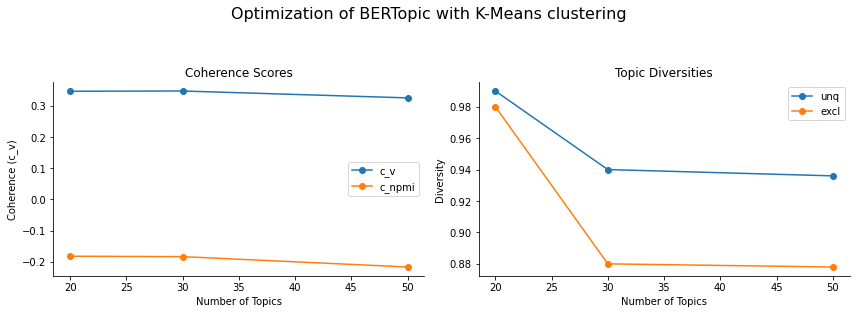

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 4))
fig.suptitle('Optimization of BERTopic with K-Means clustering', fontsize=16, y=1.08)

# Plot coherence scores
ax1 = plt.subplot(1, 2, 1)
ax1.plot(cluster_range, cv_scores, marker='o', label = 'c_v')
ax1.plot(cluster_range, cnpmi_scores, marker='o', label = 'c_npmi')
ax1.title.set_text('Coherence Scores')
ax1.legend()
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence (c_v)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Plot topic diversities
ax2 = plt.subplot(1, 2, 2)
ax2.plot(cluster_range, topic_uniqueness, marker='o', label = 'unq')
ax2.plot(cluster_range, topic_exclusivity, marker='o', label = 'excl')
ax2.title.set_text('Topic Diversities')
ax2.legend()
ax2.set_xlabel('Number of Topics')
ax2.set_ylabel('Diversity')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()

# Save the figure
fig.savefig('training_results/bertopic_kmeans_optimization.png', bbox_inches='tight', dpi=300)

plt.show()


<span style="color: red; font-family: Calibri Light;">
  <h2><b>IV. TRAIN MODEL WITH SELECTED NUMBER OF TOPICS</b></h2>
</span>

In [17]:
# Prepare data, extract embeddings, and prepare sub-models

#prepare data for bertopic model
#docs = train_data['clean_text'].values

#umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=182)
kmeans_model = KMeans(n_clusters = 30,init = 'k-means++',n_init = 10, max_iter = 300, random_state = 25)
#vectorizer_model = CountVectorizer(stop_words="english")
#sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
#embeddings = sentence_model.encode(docs, show_progress_bar=True)
#representation_model = MaximalMarginalRelevance(diversity = 0.8)


# We reduce our embeddings to 2D as it will allows us to quickly iterate later on
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, 
                          min_dist=0.0, metric='cosine').fit_transform(embeddings)

start_time = time.time()

# Train our topic model
model = BERTopic(embedding_model=sentence_model, umap_model=umap_model, 
                 hdbscan_model = kmeans_model,vectorizer_model=vectorizer_model)

topics,_ = model.fit_transform(docs, embeddings)
print (f"This project took {(time.time() - start_time)/60 :.2f} minutes to complete")

This project took 2.73 minutes to complete


In [19]:
#save model
model.save("../bertopic_models/model3_kmeans")
print ('model saved')

/usr/local/lib64/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



model saved


In [13]:
#load model
model = BERTopic.load("../bertopic_models/model3_kmeans")

In [14]:
topics_df = model.get_topic_info()
topics_df

,Topic,Count,Name,Representation,Representative_Docs
0,0,6129,0_lane_car_driving_speed,"[lane, car, driving, speed, cars, road, drive,...","[Are you driving in the ""fast"" lane?, That hap..."
1,1,5833,1_thank_thanks_good_hope,"[thank, thanks, good, hope, know, man, dm, sor...","[Thank you, will try it out sometime., Thank y..."
2,2,5475,2_post_news_comment_sub,"[post, news, comment, sub, reddit, just, don, ...",[well it's definitely more of a news source th...
3,3,5444,3_food_chicken_shawarma_burger,"[food, chicken, shawarma, burger, restaurant, ...",[For me that's the look I get when I empty my ...
4,4,5227,4_people_don_just_women,"[people, don, just, women, like, kids, know, t...",[Just don’t be creepy and take a hint. If a gi...
5,5,5219,5_card_bank_aed_credit,"[card, bank, aed, credit, money, pay, rent, ca...",[If there was an OTP and you said you never re...
6,6,4821,6_job_salary_company_work,"[job, salary, company, work, people, pay, mone...",[Dont understand the downvotes. People don't w...
7,7,4660,7_dubai_uae_people_country,"[dubai, uae, people, country, like, just, don,...",[If people dont respect the local culture they...
8,8,4318,8_racism_people_racist_indian,"[racism, people, racist, indian, country, indi...","[So you are saying if she was indian, had plac..."
9,9,4246,9_dubai_abu_dhabi_abu dhabi,"[dubai, abu, dhabi, abu dhabi, sharjah, emirat...","[Do you have those in Dubai too?, Which part o..."


In [20]:
topics_df.to_csv('training_results/bert_kmeans_30topics_terms.csv')

In [48]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,6712,0_uae_dubai_people_country,"[uae, dubai, people, country, like, work, just...","[Hey, what about the Yemen war? And the fact t..."
1,1,6557,1_car_lane_driving_speed,"[car, lane, driving, speed, cars, road, drive,...",[Okay. I accept that was bad thing. I will cor...
2,2,5670,2_food_chicken_shawarma_burger,"[food, chicken, shawarma, burger, milk, restau...",[EATING THE CHEAPEST FOOD IN DUBAI | $1 STREET...
3,3,5361,3_dubai_abu_dhabi_abu dhabi,"[dubai, abu, dhabi, abu dhabi, uae, sharjah, c...","[The ying and yang of Dubai motoring , petitio..."
4,4,5220,4_thank_thanks_good_sorry,"[thank, thanks, good, sorry, hope, lol, post, ...","[Ay! Thank you for that! Love the name!, This ..."
5,5,4763,5_job_salary_company_work,"[job, salary, company, work, people, pay, mone...","[They have a hard job but get paid very low, H..."
6,6,4335,6_people_don_just_comment,"[people, don, just, comment, like, dear, know,...","[this happen in all of reddit, its sad, I ask ..."
7,7,4233,7_racism_people_racist_country,"[racism, people, racist, country, indian, whit...","[Dude , youre still being an ignorant racist ...."
8,8,4112,8_water_hot_heat_rain,"[water, hot, heat, rain, summer, hair, weather...","[Water is water, and it only has one job - to ..."
9,9,3925,9_card_bank_aed_credit,"[card, bank, aed, credit, money, cards, pay, a...",[Is it a bad idea to get a credit card? So I d...


In [16]:
model.visualize_barchart(topics = [0,5,6,8,13])

In [17]:
model.visualize_barchart(top_n_topics=30, n_words = 10)

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>V. Retrieve Data with Topic Assignments</b></h2>
</span>

In [18]:
#create dataframe with topic assignments
t_df = model.get_document_info(docs)
t_df.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,That dessert's a bit rich for me.,3,3_food_chicken_shawarma_burger,"[food, chicken, shawarma, burger, restaurant, ...",[For me that's the look I get when I empty my ...,food - chicken - shawarma - burger - restauran...,False
1,"""A SILVER one?! I HATE YOU DAD!""",1,1_thank_thanks_good_hope,"[thank, thanks, good, hope, know, man, dm, sor...","[Thank you, will try it out sometime., Thank y...",thank - thanks - good - hope - know - man - dm...,False
2,Yet i stared at the picture for a good 45 seco...,10,10_video_like_italian_guy,"[video, like, italian, guy, picture, music, lo...","[The guy doesn’t own it, he just found the pic...",video - like - italian - guy - picture - music...,False
3,"[FYSR] = from your sister subreddit. IMO, its ...",7,7_dubai_uae_people_country,"[dubai, uae, people, country, like, just, don,...",[If people dont respect the local culture they...,dubai - uae - people - country - like - just -...,False
4,common give prince william harry a break he ju...,10,10_video_like_italian_guy,"[video, like, italian, guy, picture, music, lo...","[The guy doesn’t own it, he just found the pic...",video - like - italian - guy - picture - music...,False


In [19]:
#topic assignment column subset
assigned_topics = t_df[['Topic', 'Name']].copy()
assigned_topics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98957 entries, 0 to 98956
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Topic   98957 non-null  int64 
 1   Name    98957 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [20]:
train_data_label = train_data.copy() #create copy of training data

In [21]:
train_data_label.reset_index(drop = True, inplace = True) #reindex to match topic assignemtn index

In [22]:
train_data_label[['topic', 'topic_name']] = assigned_topics #merge data

In [23]:
train_data_label.head()

,text_type,ID,date_created,year,long_text,prep_text,topic,topic_name
0,comment,c5c54q4,2012-07-11 00:50:58,2012,That dessert's a bit rich for me.,That dessert's a bit rich for me.,3,3_food_chicken_shawarma_burger
1,comment,c5edn0u,2012-07-15 21:59:34,2012,"""A SILVER one?! I HATE YOU DAD!""","""A SILVER one?! I HATE YOU DAD!""",1,1_thank_thanks_good_hope
2,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...,Yet i stared at the picture for a good 45 seco...,10,10_video_like_italian_guy
3,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i...","[FYSR] = from your sister subreddit. IMO, its ...",7,7_dubai_uae_people_country
4,comment,c6d46es,2012-09-25 12:32:08,2012,common give prince william harry a break he ju...,common give prince william harry a break he ju...,10,10_video_like_italian_guy


In [24]:
train_data_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98957 entries, 0 to 98956
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_type     98957 non-null  object
 1   ID            98957 non-null  object
 2   date_created  98957 non-null  object
 3   year          98957 non-null  int64 
 4   long_text     98957 non-null  object
 5   prep_text     98957 non-null  object
 6   topic         98957 non-null  int64 
 7   topic_name    98957 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.0+ MB


In [25]:
train_data_label.to_csv('training_results/bert_model_kmeans_label_train_data.csv') #save dataframe